## ATAC + MULTIOME males (september 2021)

### Label transfer with Seurat 

In [22]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata
sc.settings.figdir = '/home/jovyan/MULTIOME_july2021/figures_males/'

In [23]:
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

In [24]:
import rpy2.rinterface_lib.callbacks
import logging

In [25]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [26]:
import anndata2ri
anndata2ri.activate()

In [27]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
%%R
## Install dependencies
#devtools::install_github("aertslab/RcisTarget")
#devtools::install_github("aertslab/AUCell")
        
#devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)
library(Seurat)
library(dplyr)
library(data.table)
library(GenomicRanges)
library(EnsDb.Hsapiens.v86)
#library(cicero)
library(Signac)
#library(clustree)
library(Matrix)
library(reticulate)
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("mojaveazure/seurat-disk")

library(SeuratDisk)

In [29]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

**Load data**

In [30]:
# Define variables
outdir = "/nfs/team292/vl6/my_MULTIOME_dir/males_sept2021/"
experiment_prefix = 'males_'

Try to use the gene accessibility scores computed with cisTopic and integrate with matched scRNAseq samples annotated by Luz 

In [9]:
%%R -i outdir -i experiment_prefix -o ATAC_geneScores
Convert(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"), overwrite = TRUE)
ATAC_geneScores <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_ATAC.geneScores.h5seurat"))
ATAC_geneScores
table(ATAC_geneScores@meta.data$individual)

 [1] 6752 2862 3574 8464 4607 5390 5320 6147 5234 5695


In [10]:
%%R -i outdir -i experiment_prefix -o RNAseq
Convert(paste0(outdir, experiment_prefix, "_RNAseq.h5ad"),  
        dest = paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"), overwrite = TRUE, verbose = TRUE)

RNAseq <- LoadH5Seurat(paste0(outdir, experiment_prefix, "_RNAseq.h5seurat"))
RNAseq
table(RNAseq@meta.data$donor)

 [1] 2606 3378  694 4969 2171 5001 3075 5793 4340 8322


In [11]:
%%R -i RNAseq

print(table(RNAseq@meta.data$lineage)) 


          CoelEpi       Endothelial        Epithelial         Erythroid 
             1570              2334              2115               695 
      FetalLeydig         GermCells            Immune Mesenchymal_GATA2 
             1531              1558              1646              8000 
 Mesenchymal_LHX9            Neural                PV           Sertoli 
             8000              1579              1053              8000 
       Supporting 
             2268 


**Try label transfer with major cluster annotations**

In [12]:
%%R -i RNAseq -i ATAC_geneScores -o RNA2ATAC

# Normalize both RNA and ATAC data
RNAseq <- NormalizeData(object = RNAseq, verbose = TRUE)
ATAC_geneScores <- NormalizeData(object = ATAC_geneScores, verbose = TRUE)

# Find HVGs in both RNA and ATAC data
RNAseq  <- FindVariableFeatures(object = RNAseq, selection.method = "vst", nfeatures = 3000, verbose = TRUE)
ATAC_geneScores <- FindVariableFeatures(object = ATAC_geneScores, selection.method = "vst", nfeatures = 3000, verbose = TRUE)

# Find anchors to do integration using RNA as reference and ATAC as query 
transfer_anchors <- FindTransferAnchors(reference = RNAseq, query = ATAC_geneScores, 
    dims = 1:25, reduction = "cca")

# Transfer labels from RNA to ATAC
RNA2ATAC <- TransferData(anchorset = transfer_anchors, refdata = RNAseq@meta.data$lineage, dims = 1:25, weight.reduction = "cca",
                        prediction.assay = TRUE)

# Add metadata to ATAC
#ATAC_geneScores_labels <- AddMetaData(object = ATAC_geneScores, metadata = RNA2ATAC)

In [13]:
%%R -i RNA2ATAC -o predicted_probabilities -i ATAC_geneScores

ATAC_geneScores[['scores']] <- RNA2ATAC
ATAC_geneScores
DefaultAssay(ATAC_geneScores) <- "scores" # Change default assay 
predicted_probabilities <- as.data.frame(t(x = as.matrix(x = GetAssayData(object = ATAC_geneScores))))

In [14]:
predicted_probabilities

Immune  Erythroid  GermCells  Mesenchymal-LHX9  \
03-AAACGAAAGCTGAGGT-1     0.0        0.0   0.000000          0.000000   
03-AAACGAACAATCATCG-1     0.0        0.0   0.000000          0.000000   
03-AAACGAACATGCACTA-1     0.0        0.0   0.137878          0.028463   
03-AAACTCGTCACCCGGA-1     0.0        0.0   0.000000          0.000000   
03-AAACTGCCAAGGGTAC-1     0.0        0.0   0.000000          0.000000   
...                       ...        ...        ...               ...   
12-TTTGTGTGTCTAACCA-1     0.0        0.0   0.000000          0.006016   
12-TTTGTGTGTTAGGCTT-1     0.0        0.0   0.000000          0.000000   
12-TTTGTGTGTTCCAGTA-1     0.0        0.0   0.000000          0.000000   
12-TTTGTGTGTTTAGAAG-1     0.0        0.0   0.000000          0.418001   
12-TTTGTGTTCTCGTAGA-1     0.0        0.0   0.000000          0.013190   

                       FetalLeydig  Epithelial   Sertoli   PV  \
03-AAACGAAAGCTGAGGT-1     0.000000         0.0  1.000000  0.0   
03-AAACGAACAATCATCG-1     0.000000         0.0  1.000000  0.0   
03-AAACGAACATGCACTA-1     0.000000         0.0  0.512352  0.0   
03-AAACTCGTCACCCGGA-1     0.000000         0.0  1.000000  0.0   
03-AAACTGCCAAGGGTAC-1     0.000000         0.0  0.000000  0.0   
...                            ...         ...       ...  ...   
12-TTTGTGTGTCTAACCA-1     0.000000         0.0  0.017465  0.0   
12-TTTGTGTGTTAGGCTT-1     0.000000         0.0  1.000000  0.0   
12-TTTGTGTGTTCCAGTA-1     0.000000         0.0  0.000000  0.0   
12-TTTGTGTGTTTAGAAG-1     0.040336         0.0  0.541663  0.0   
12-TTTGTGTTCTCGTAGA-1     0.000000         0.0  0.986810  0.0   

                       Mesenchymal-GATA2  Endothelial  CoelEpi  Supporting  \
03-AAACGAAAGCTGAGGT-1           0.000000          0.0      0.0    0.000000   
03-AAACGAACAATCATCG-1           0.000000          0.0      0.0    0.000000   
03-AAACGAACATGCACTA-1           0.295005          0.0      0.0    0.026301   
03-AAACTCGTCACCCGGA-1           0.000000          0.0      0.0    0.000000   
03-AAACTGCCAAGGGTAC-1           0.000000          0.0      1.0    0.000000   
...                                  ...          ...      ...         ...   
12-TTTGTGTGTCTAACCA-1           0.976519          0.0      0.0    0.000000   
12-TTTGTGTGTTAGGCTT-1           0.000000          0.0      0.0    0.000000   
12-TTTGTGTGTTCCAGTA-1           0.000000          1.0      0.0    0.000000   
12-TTTGTGTGTTTAGAAG-1           0.000000          0.0      0.0    0.000000   
12-TTTGTGTTCTCGTAGA-1           0.000000          0.0      0.0    0.000000   

                       Neural       max  
03-AAACGAAAGCTGAGGT-1     0.0  1.000000  
03-AAACGAACAATCATCG-1     0.0  1.000000  
03-AAACGAACATGCACTA-1     0.0  0.512352  
03-AAACTCGTCACCCGGA-1     0.0  1.000000  
03-AAACTGCCAAGGGTAC-1     0.0  1.000000  
...                       ...       ...  
12-TTTGTGTGTCTAACCA-1     0.0  0.976519  
12-TTTGTGTGTTAGGCTT-1     0.0  1.000000  
12-TTTGTGTGTTCCAGTA-1     0.0  1.000000  
12-TTTGTGTGTTTAGAAG-1     0.0  0.541663  
12-TTTGTGTTCTCGTAGA-1     0.0  0.986810  

[54045 rows x 14 columns]

In [15]:
predicted_probabilities.columns

Index(['Immune', 'Erythroid', 'GermCells', 'Mesenchymal-LHX9', 'FetalLeydig',
       'Epithelial', 'Sertoli', 'PV', 'Mesenchymal-GATA2', 'Endothelial',
       'CoelEpi', 'Supporting', 'Neural', 'max'],
      dtype='object')

Replace dashes with underscores as stupid R changes them

In [16]:
predicted_probabilities.columns = ['Immune', 'Erythroid', 'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig',
       'Epithelial', 'Sertoli', 'PV', 'Mesenchymal_GATA2', 'Endothelial',
       'CoelEpi', 'Supporting', 'Neural', 'max']

**Save the predicted annotations to the gene activity anndata object for ATAC**

In [17]:
gene_data = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")
gene_data

AnnData object with n_obs × n_vars = 54045 × 19085
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual'
    var: 'gene_id'
    uns: 'neighbors', 'umap'
    obsm: 'X_cistopic_38', 'X_umap'
    obsp: 'connectivities', 'distances'

In [18]:
for pred in predicted_probabilities.columns: 
    print(pred)
    gene_data.obs[pred] = predicted_probabilities[pred]

Immune
Erythroid
GermCells
Mesenchymal_LHX9
FetalLeydig
Epithelial
Sertoli
PV
Mesenchymal_GATA2
Endothelial
CoelEpi
Supporting
Neural
max


In [10]:
gonads_colors = ['royalblue', 'orange', 'green', 'red', 'orchid', 'lightgrey', 'brown', 'pink', 'yellowgreen', 
                'deepskyblue', 'cadetblue', 'mediumpurple', 'darkkhaki']

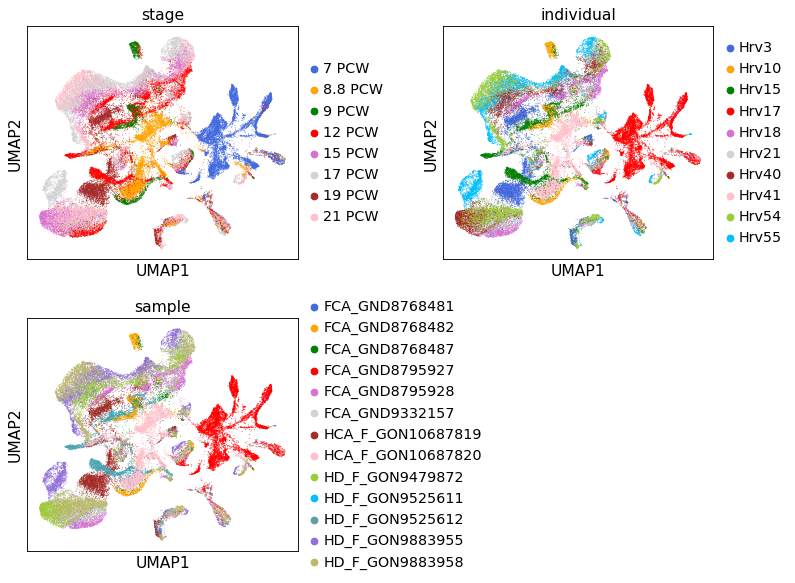

In [20]:
sc.pl.umap(gene_data, color = ['stage', 'individual', 'sample'], ncols = 2, wspace = 0.4, 
           palette = gonads_colors, save = "_noharmony.pdf")

In [21]:
gene_data.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic',
       'code', 'sample', 'sex', 'stage', 'individual', 'Immune', 'Erythroid',
       'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli',
       'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting',
       'Neural', 'max'],
      dtype='object')

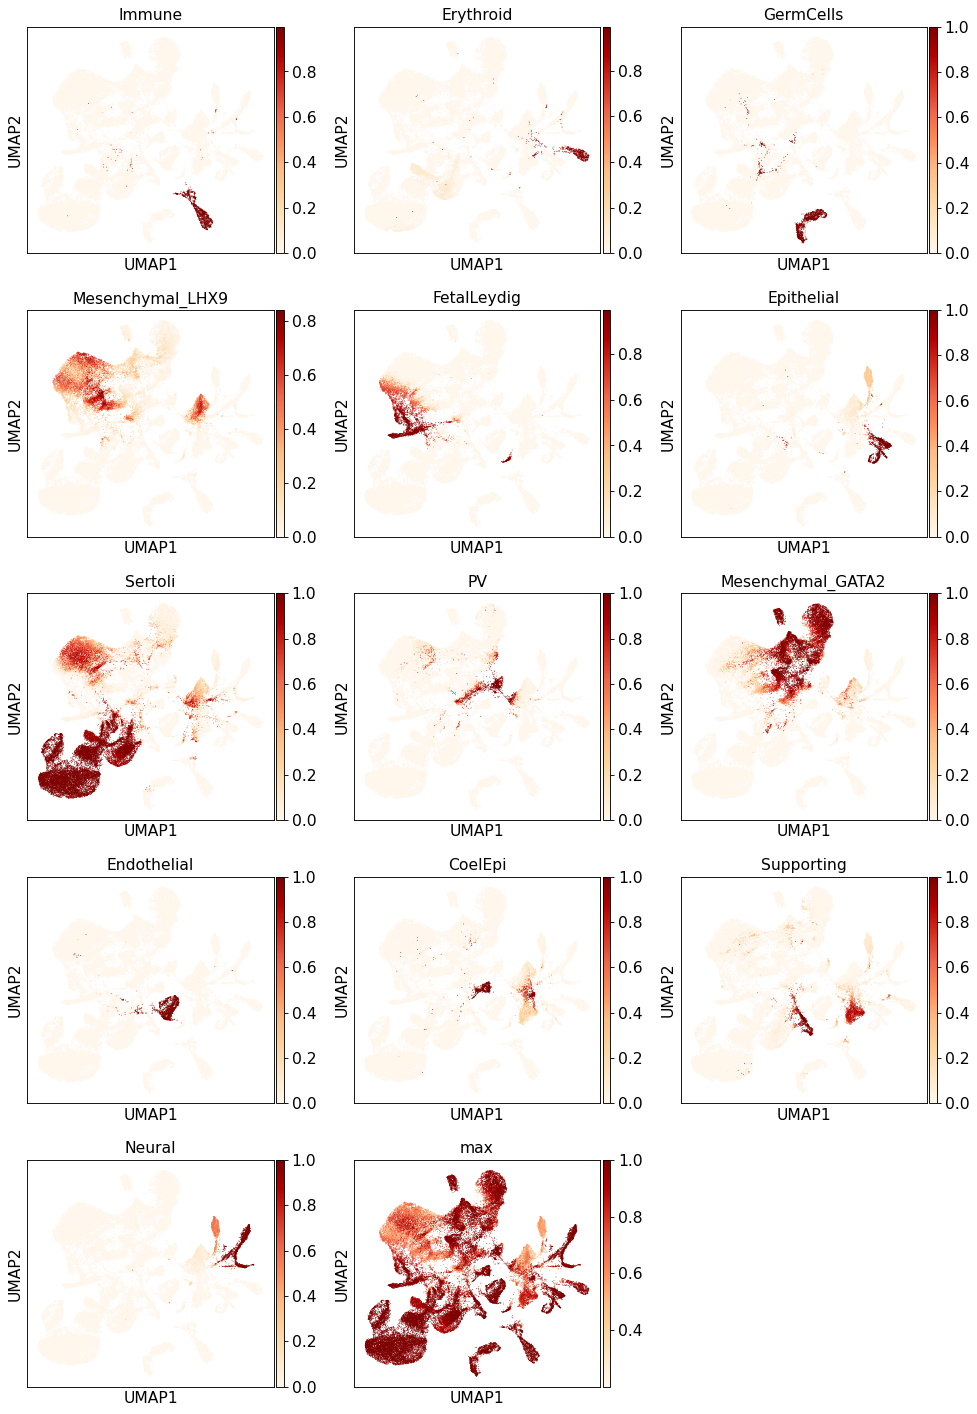

In [22]:
sc.pl.umap(gene_data, color = ['Immune', 'Erythroid',
       'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli',
       'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting',
       'Neural', 'max'], ncols = 3, color_map = 'OrRd', save = "_probs_noharmony.pdf")

#### Look at average gene activity scores to identify cycling population

This was suggested by Luz 

In [23]:
gene_data.X

array([[53., 49., 49., ..., 40.,  1., 15.],
       [44., 42., 42., ..., 42.,  1., 15.],
       [35., 38., 38., ..., 26.,  5., 13.],
       ...,
       [51., 28., 28., ..., 23.,  3.,  2.],
       [36., 19., 19., ..., 18.,  6.,  2.],
       [27., 31., 31., ..., 21.,  6., 12.]], dtype=float32)

In [24]:
mean_by_cell = gene_data.X.mean(axis=1)
mean_by_cell

array([56.016872, 55.706314, 52.928425, ..., 55.830494, 53.299084,
       53.276604], dtype=float32)

In [25]:
means = pd.DataFrame(mean_by_cell, columns=['mean_gene_activity'], index=gene_data.obs_names)
means.head()

mean_gene_activity
03-AAACGAAAGCTGAGGT-1           56.016872
03-AAACGAACAATCATCG-1           55.706314
03-AAACGAACATGCACTA-1           52.928425
03-AAACTCGTCACCCGGA-1           55.351795
03-AAACTGCCAAGGGTAC-1           54.814251

In [26]:
gene_data.obs['mean_gene_activity'] = means

In [27]:
# sc.pl.umap(gene_data, color = ['mean_gene_activity', 'CKS1B', 'SMC4', 'KIF11'], ncols = 2, color_map = "OrRd")

In [28]:
cell_cycle_genes = [x.strip() for x in open(file='/nfs/users/nfs_v/vl6/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in gene_data.var_names]
print(s_genes)
g2m_genes = [x for x in g2m_genes if x in gene_data.var_names]
print(g2m_genes)

['MCM5', 'FEN1', 'MCM2', 'UNG', 'GINS2', 'MCM6', 'DTL', 'UHRF1', 'RFC2', 'WDR76', 'SLBP', 'POLD3', 'MSH2', 'ATAD2', 'RRM2', 'CDC45', 'CDC6', 'BLM', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1']
['BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'NUF2', 'CENPF', 'TACC3', 'FAM64A', 'CKAP2', 'TUBB4B', 'GTSE1', 'HJURP', 'CDCA3', 'HN1', 'RANGAP1', 'CDCA2', 'ECT2', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']


In [29]:
#sc.pl.umap(gene_data, color = s_genes, color_map = "OrRd")

In [30]:
#sc.pl.umap(gene_data, color = g2m_genes, color_map = "OrRd")

In [31]:
gene_data.write(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")

In [32]:
gene_data

AnnData object with n_obs × n_vars = 54045 × 19085
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'Immune', 'Erythroid', 'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli', 'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting', 'Neural', 'max', 'mean_gene_activity'
    var: 'gene_id'
    uns: 'neighbors', 'umap', 'stage_colors', 'individual_colors', 'sample_colors'
    obsm: 'X_cistopic_38', 'X_umap'
    obsp: 'connectivities', 'distances'

**Save the predicted annotations to the peaks anndata object for ATAC**

In [33]:
adata = sc.read_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")
adata

AnnData object with n_obs × n_vars = 54045 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cistopic_38', 'X_umap'
    varm: 'peak2gene'
    layers: 'binary_raw'
    obsp: 'connectivities', 'distances'

In [34]:
for pred in predicted_probabilities.columns: 
    print(pred)
    adata.obs[pred] = predicted_probabilities[pred]

Immune
Erythroid
GermCells
Mesenchymal_LHX9
FetalLeydig
Epithelial
Sertoli
PV
Mesenchymal_GATA2
Endothelial
CoelEpi
Supporting
Neural
max


### Harmony integration

In [35]:
adata

AnnData object with n_obs × n_vars = 54045 × 184906
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic', 'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score', 'doublet_score_0.75', 'Immune', 'Erythroid', 'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli', 'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting', 'Neural', 'max'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'chromosome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cellatac_clusters_colors', 'individual_colors', 'neighbors', 'sample_colors', 'sex_colors', 'stage_colors', 'umap'
    obsm: 'X_cisto

In [36]:
# Extract PCA matrix and batch array
n_pcs = 38
pca = adata.obsm['X_cistopic_38'][:, 0:(n_pcs)]
batch = adata.obs['individual']

In [37]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)
set.seed(1000)
hem <- HarmonyMatrix(pca, batch, theta=0, do_pca=FALSE, verbose = FALSE)
hem = data.frame(hem)

In [38]:
# Add harmony values to the anndata object
adata.obsm['X_harmony'] = hem.values

In [39]:
sc.pp.neighbors(adata, use_rep= 'X_harmony', random_state=1234)

In [40]:
sc.tl.umap(adata,  min_dist = 0.5, spread = 1)

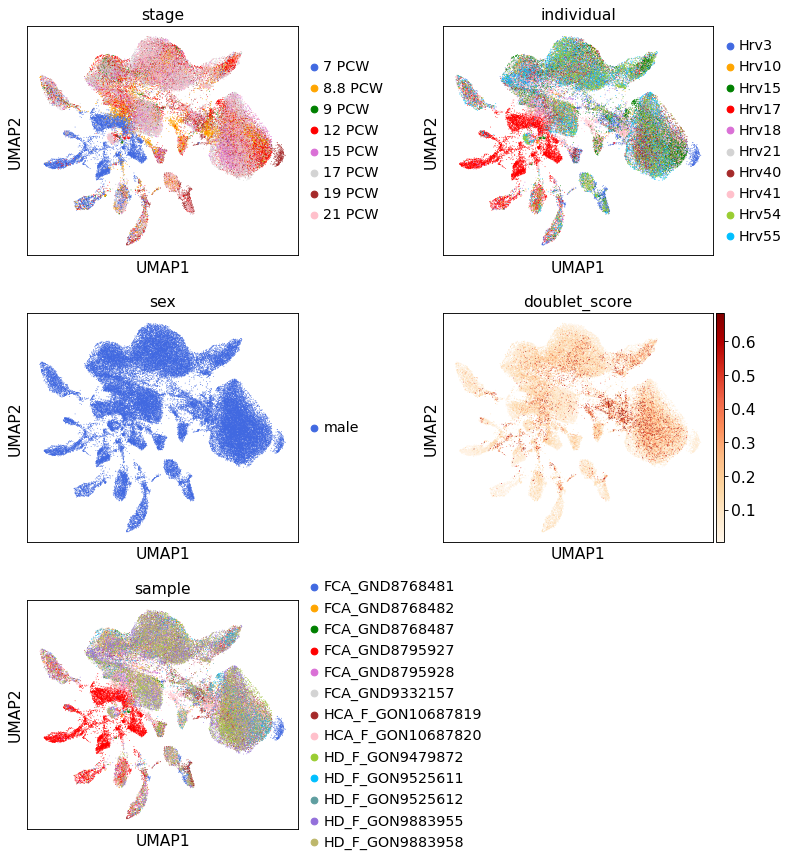

In [41]:
sc.pl.umap(adata, color = ['stage', 'individual', 'sex', 'doublet_score', 'sample'], ncols = 2, wspace = 0.4, 
           palette = gonads_colors, save = "metadata.pdf", color_map = 'OrRd')

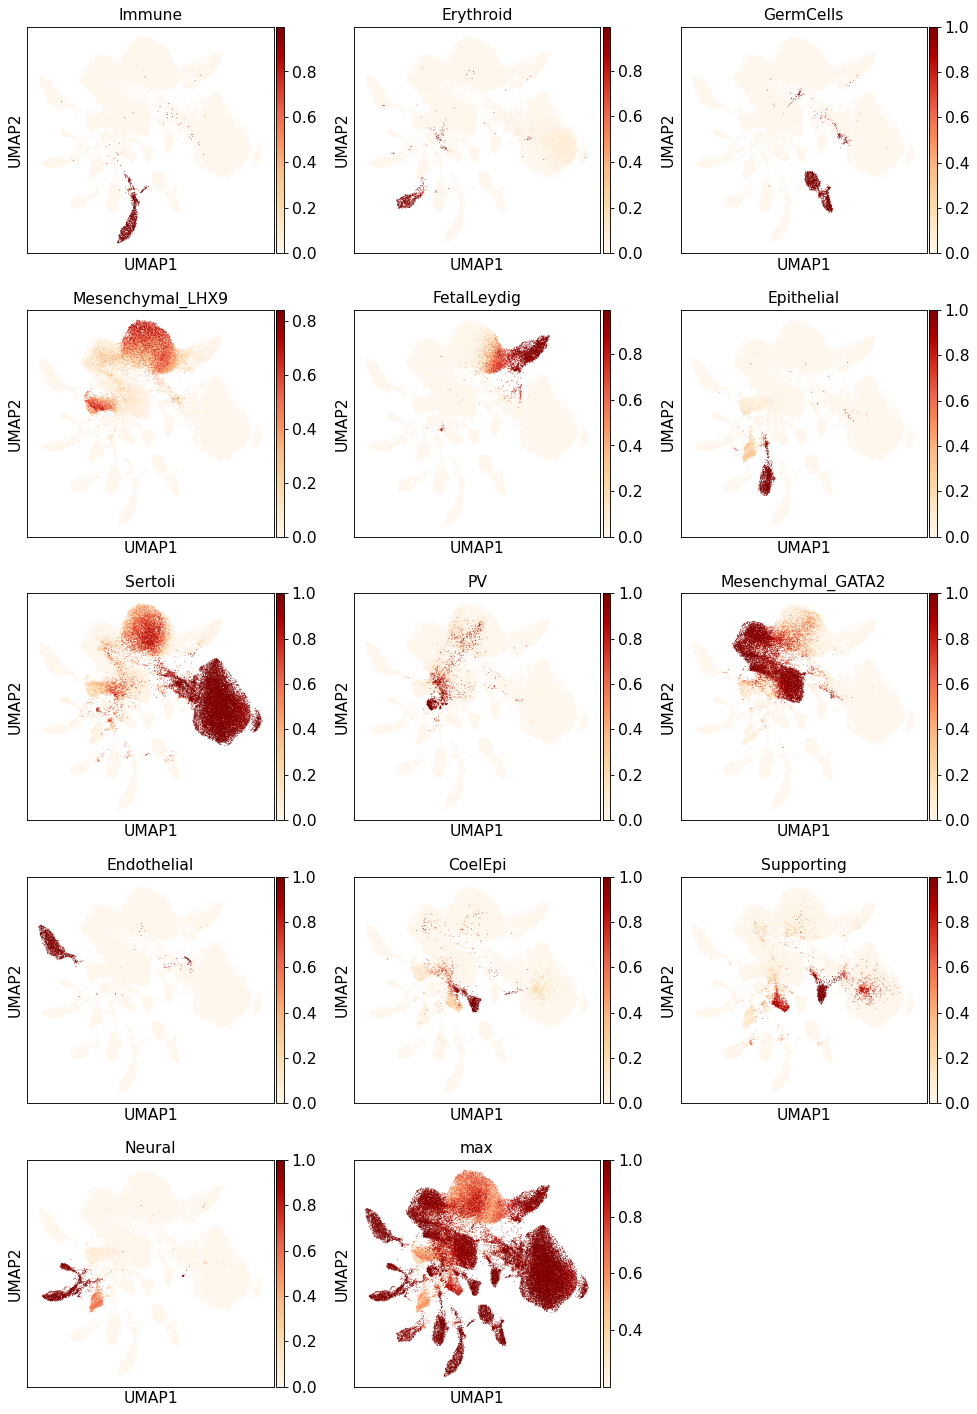

In [42]:
sc.pl.umap(adata, color = ['Immune', 'Erythroid',
       'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli',
       'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting',
       'Neural', 'max'],
           ncols = 3, color_map = 'OrRd', save = "_probs_harmony.pdf")

#### Visualize position in the manifold of dual ATAC samples

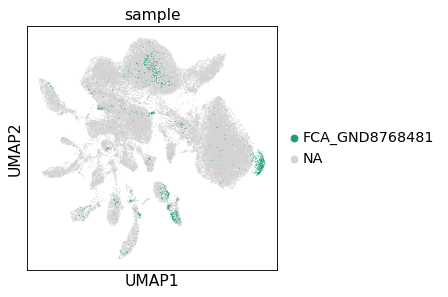

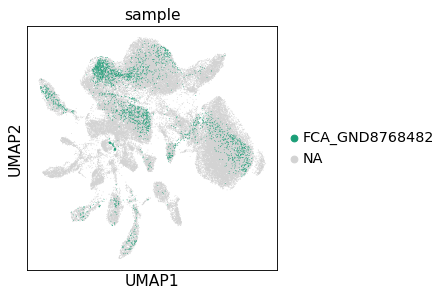

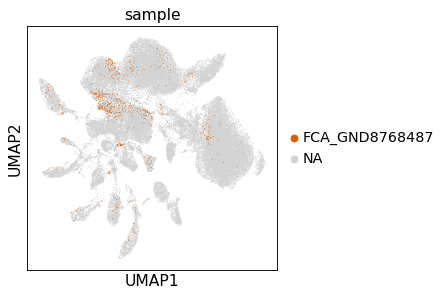

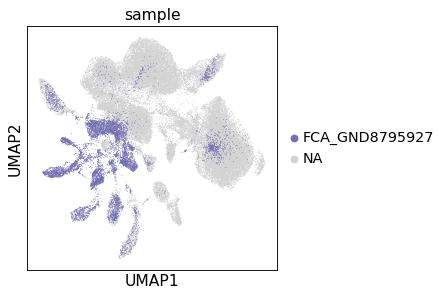

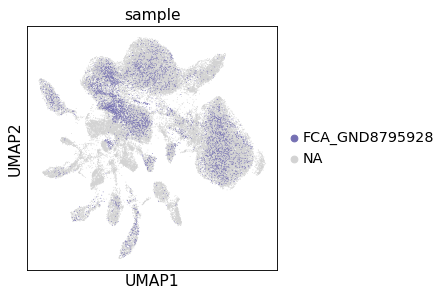

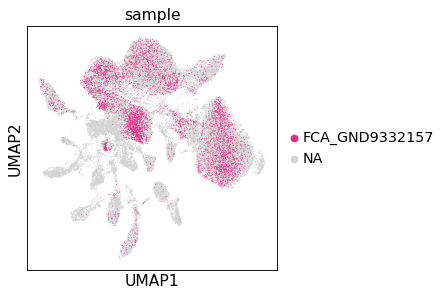

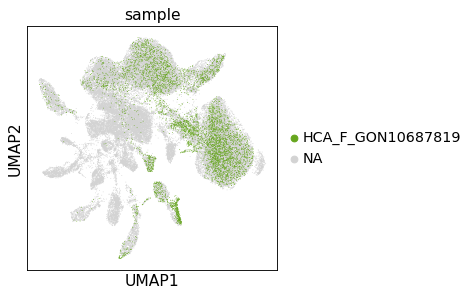

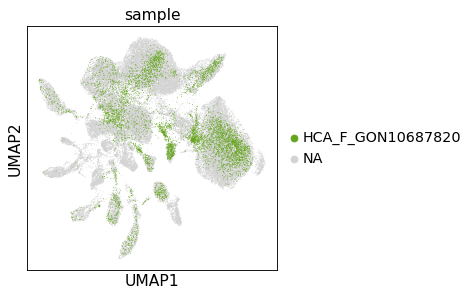

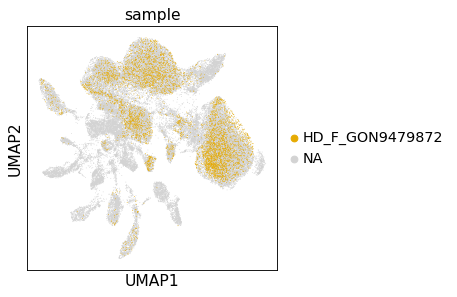

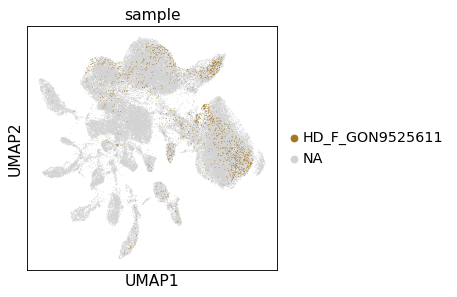

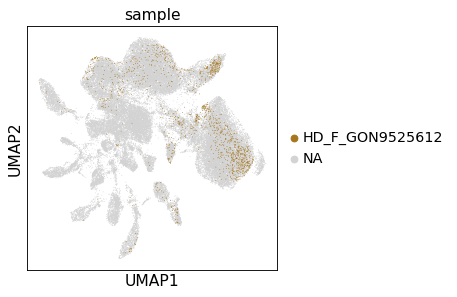

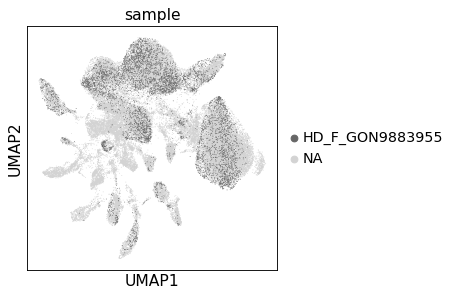

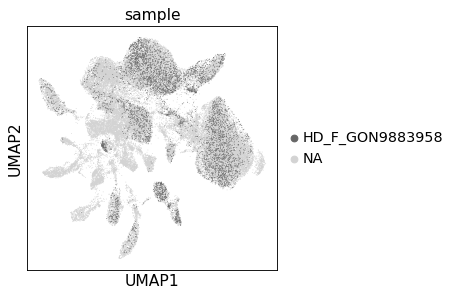

In [43]:
for sample in np.unique(adata.obs['sample']):
    sc.pl.umap(adata, color = 'sample', groups = sample, palette = 'Dark2', save = sample + ".pdf")

#### Clustering

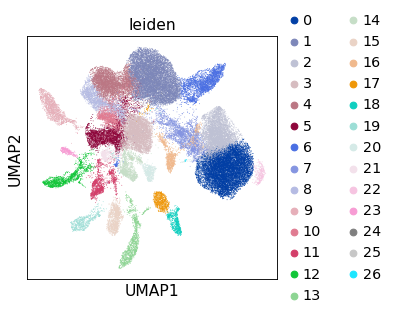

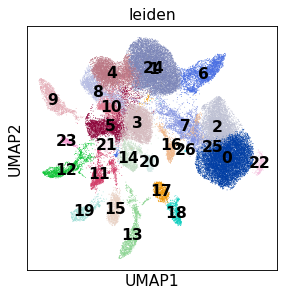

In [44]:
sc.tl.leiden(adata, resolution= 0.8, random_state = 1234)
sc.pl.umap(adata, color='leiden',save='_clustering.pdf')
sc.pl.umap(adata, color='leiden',legend_loc='on data',save='_clustering_clusnumbers.pdf')

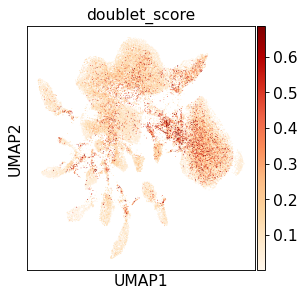

In [45]:
sc.pl.umap(adata, color = ['doublet_score'], color_map = 'OrRd')

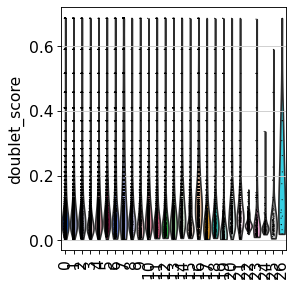

In [46]:
sc.pl.violin(adata, keys = ['doublet_score'], groupby = 'leiden', rotation = 90)

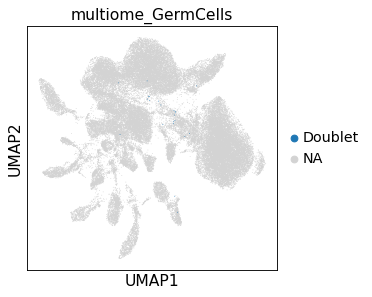

In [59]:
sc.pl.umap(adata, color = ['multiome_GermCells'], groups = ['Doublet'])

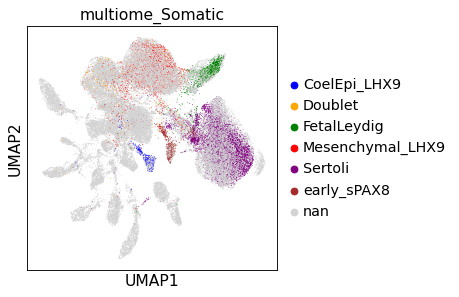

In [63]:
sc.pl.umap(adata, color = ['multiome_Somatic'], palette = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'lightgrey'])

In [64]:
# Remove cluster 26 of doublets
adata = adata[[i not in ['26'] for i in adata.obs['leiden']]]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [65]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

#### Matrixplot of label transfer predictions vs leiden clusters

In [11]:
adata.obs.columns

Index(['cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'multiome_GermCells', 'multiome_Somatic',
       'code', 'sample', 'sex', 'stage', 'individual', 'doublet_score',
       'doublet_score_0.75', 'Immune', 'Erythroid', 'GermCells',
       'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli', 'PV',
       'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting', 'Neural',
       'max', 'leiden', 'cell_type', 'matching_barcode', 'somatic_annotation'],
      dtype='object')

In [12]:
obs = adata.obs[[ 'Immune', 'Erythroid',
       'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli',
       'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting',
       'Neural'
       ]]

In [13]:
matrix = obs[['Immune', 'Erythroid',
       'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli',
       'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting',
       'Neural'
       ]].values
matrix.shape

(52285, 13)

In [14]:
plotting_obs = adata.obs[['leiden', 'individual', 'cell_type']]
plotting_obs.shape

(52285, 3)

In [15]:
plotting_probs = ['Immune', 'Erythroid',
       'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli',
       'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting',
       'Neural'
       ]
plotting_var_dict = {'probs' : plotting_probs, 'random_string' : [str(i) for i in range(13)]}
plotting_var = pd.DataFrame(plotting_var_dict)
plotting_var = plotting_var.set_index('probs')
plotting_var.head()
plotting_var.shape

(13, 1)

In [16]:
plotting_adata = anndata.AnnData(X = matrix, obs = plotting_obs, var = plotting_var)
plotting_adata

AnnData object with n_obs × n_vars = 52285 × 13
    obs: 'leiden', 'individual', 'cell_type'
    var: 'random_string'

In [17]:
ordered_probs = ['Immune', 'Erythroid',
       'GermCells', 'Mesenchymal_LHX9', 'FetalLeydig', 'Epithelial', 'Sertoli',
       'PV', 'Mesenchymal_GATA2', 'Endothelial', 'CoelEpi', 'Supporting',
       'Neural'
       ]

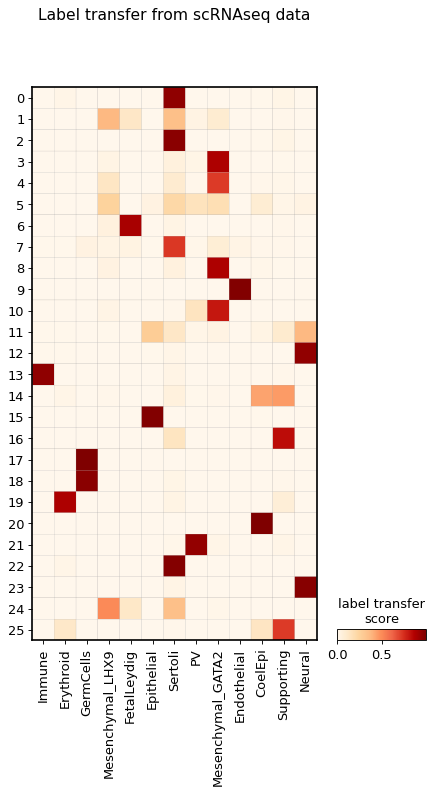

In [18]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'leiden', cmap = 'OrRd',
                  save = '_leiden.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

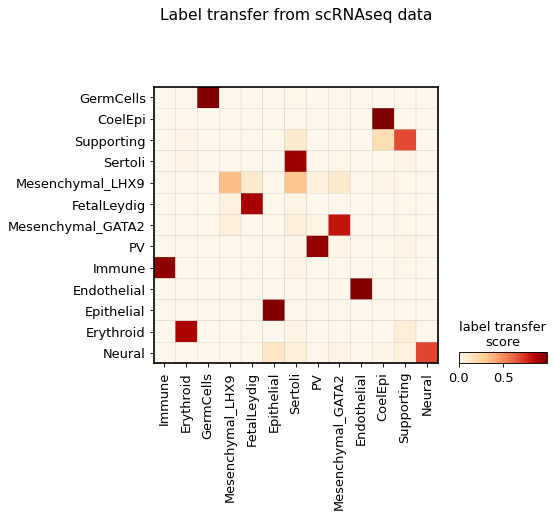

In [19]:
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

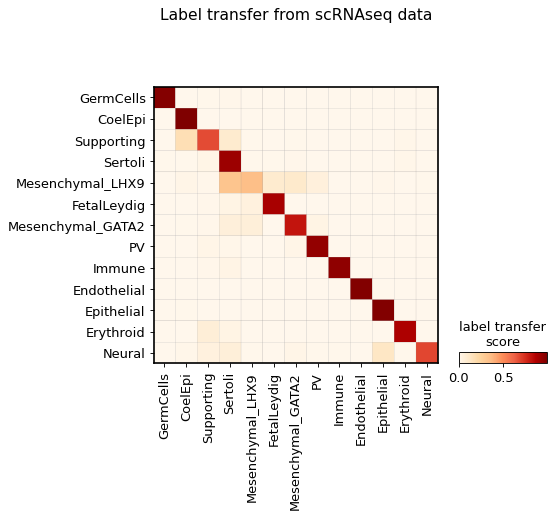

In [20]:
ordered_probs_present = ['GermCells',  'CoelEpi', 
                 'Supporting', 'Sertoli', 'Mesenchymal_LHX9',  'FetalLeydig', 'Mesenchymal_GATA2', 'PV',
                   'Immune', 'Endothelial',  'Epithelial', 'Erythroid', 'Neural']
sc.pl.matrixplot(plotting_adata, var_names = ordered_probs_present, groupby = 'cell_type', cmap = 'OrRd',
                  save = '_matrixplot_present.pdf', colorbar_title = "label transfer\nscore", 
                title = "Label transfer from scRNAseq data")

#### Annotate cells based on label transfer & dual annotations

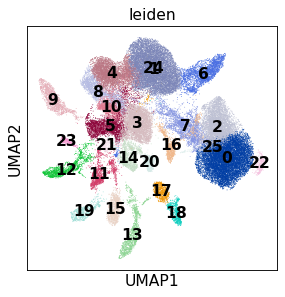

In [74]:
sc.pl.umap(adata, color = 'leiden', legend_loc = 'on data')

In [98]:
cell_type = {'13' : 'Immune', '19' : 'Erythroid', '17' : 'GermCells', '18' : 'GermCells', 
             '15' : 'Epithelial', '0' : 'Sertoli', '2' : 'Sertoli', '22' : 'Sertoli', '7' : 'Sertoli',
              '21' : 'PV', '3' : 'Mesenchymal_GATA2', 
             '4' : 'Mesenchymal_GATA2','8' : 'Mesenchymal_GATA2', '10' : 'Mesenchymal_GATA2',
              '9' : 'Endothelial', '6' : 'FetalLeydig', 
            '20' : 'CoelEpi', '26' : 'Neural', '23' : 'Neural',  '12' : 'Neural',  '11' : 'Neural',
     '1' : 'Mesenchymal_LHX9', '24' : 'Mesenchymal_LHX9', '5' : 'CoelEpi', 
             '14' : 'Supporting', '16' : 'Supporting', '25' : 'Supporting'
            }
adata.obs['cell_type'] = adata.obs['leiden'].map(cell_type)
adata.obs['cell_type'].value_counts(dropna = False)

Sertoli              17020
Mesenchymal_GATA2    11195
Mesenchymal_LHX9      8502
CoelEpi               3236
Neural                2904
FetalLeydig           2506
Supporting            2376
GermCells             1403
Endothelial           1388
Immune                1226
Epithelial            1124
Erythroid              638
PV                     511
Name: cell_type, dtype: int64

In [99]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype("category")
adata.obs['cell_type'] = adata.obs['cell_type'].cat.reorder_categories([
   'GermCells', 'CoelEpi',
     'Supporting', 'Sertoli',  'Mesenchymal_LHX9','FetalLeydig', 'Mesenchymal_GATA2', 'PV', 'Immune',  'Endothelial', 
   'Epithelial', 'Erythroid', 'Neural'
])

In [100]:
male_colors = {'GermCells' : '#e69429', 'CoelEpi' : '#378b4e', 'Supporting' : '#ffb3cd', 'Sertoli' : '#71c6fc', 
            'Mesenchymal_LHX9' : '#dacef4', 'FetalLeydig' : '#0485cb', 'Mesenchymal_GATA2' : '#fbbc04', 
               'PV' : '#d4b16c', 'Immune' : '#039eaa',  'Endothelial' : '#efd6bb', 'Epithelial' : '#b4b90e', 
               'Erythroid' : '#6fd1d3', 'Neural' : '#ffde00'}

adata.uns['lineage_colors'] = male_colors

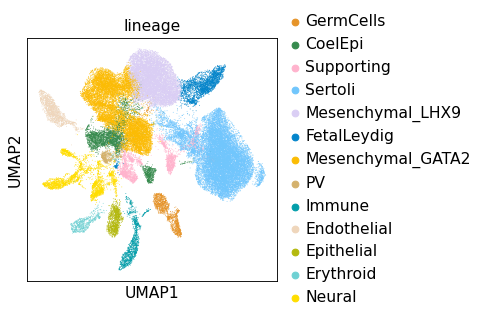

In [101]:
sc.pl.umap(adata, color = 'cell_type', palette = adata.uns['lineage_colors'], 
           legend_fontsize = "medium", legend_fontweight = "medium", frameon = True, 
           title = "lineage",
           save = "_annotations.pdf", )

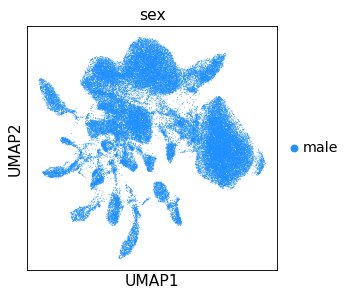

In [81]:
sc.pl.umap(adata, color = 'sex', palette = ['dodgerblue'], save = '_sex')

In [82]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

In [31]:
adata = sc.read(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

In [32]:
adata.obs['stage'].value_counts()

17 PCW     11043
12 PCW      8064
7 PCW       7486
19 PCW      6558
8.8 PCW     5784
15 PCW      5289
21 PCW      5214
9 PCW       2847
Name: stage, dtype: int64

In [33]:
stage_numeric = {'17 PCW' : 17, '12 PCW' : 12, '7 PCW' : 7, '8.8 PCW' : 8.8, '21 PCW' : 21, '15 PCW' : 15, 
                '19 PCW' : 19, '9 PCW' : 9}
adata.obs['stage_numeric'] = adata.obs.stage.map(stage_numeric)
adata.obs['stage_numeric'].value_counts(dropna = False)

17.0    11043
12.0     8064
7.0      7486
19.0     6558
8.8      5784
15.0     5289
21.0     5214
9.0      2847
Name: stage_numeric, dtype: int64

In [34]:
adata.obs['stage_numeric'] = adata.obs['stage_numeric'].astype(float)

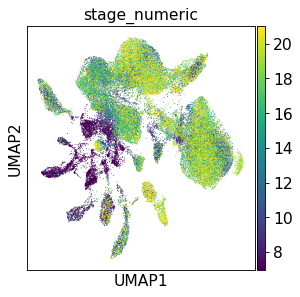

In [35]:
sc.pl.umap(adata, color = 'stage_numeric', color_map = 'viridis', save = '_stage_numeric')

In [36]:
adata.obs['multiome_GermCells'].value_counts()

nan                 51608
PGC                   216
preSpermatogonia      200
PGC_mitotic           142
GC                     97
Doublet                22
Name: multiome_GermCells, dtype: int64

In [37]:
adata.obs['multiome_GermCells'] = np.where(adata.obs['multiome_GermCells'] == 'preSpermatogonia', 'pre_spermatogonia', adata.obs['multiome_GermCells'])

In [38]:
adata.obs['multiome_GermCells'] = np.where(adata.obs['multiome_GermCells'] == 'PGC_mitotic', 'PGC', adata.obs['multiome_GermCells'])

In [39]:
adata.obs['multiome_Somatic'].value_counts()

nan                 42522
Sertoli              5747
Mesenchymal_LHX9     1918
FetalLeydig          1132
early_sPAX8           491
Doublet               260
CoelEpi_LHX9          215
Name: multiome_Somatic, dtype: int64

In [40]:
adata.obs['multiome_Somatic'] = np.where(adata.obs['multiome_Somatic'] == 'early_sPAX8', 'sPAX8', adata.obs['multiome_Somatic'])

In [41]:
adata.obs['multiome_Somatic'] = np.where(adata.obs['multiome_Somatic'] == 'nan', adata.obs['multiome_GermCells'],
                                        adata.obs['multiome_Somatic'])

In [43]:
adata.obs['multiome_Somatic'].value_counts()

nan                  41845
Sertoli               5747
Mesenchymal_LHX9      1918
FetalLeydig           1132
sPAX8                  491
PGC                    358
Doublet                282
CoelEpi_LHX9           215
pre_spermatogonia      200
GC                      97
Name: multiome_Somatic, dtype: int64

In [44]:
adata.obs['multiome_Somatic'] = adata.obs['multiome_Somatic'].astype('category')
adata.obs['multiome_Somatic'] = adata.obs['multiome_Somatic'].cat.reorder_categories(['PGC', 'GC', 'pre_spermatogonia','CoelEpi_LHX9', 'sPAX8', 'Sertoli',
                                                                                      'FetalLeydig', 'Mesenchymal_LHX9', 
                                                                                     'nan', 'Doublet'])

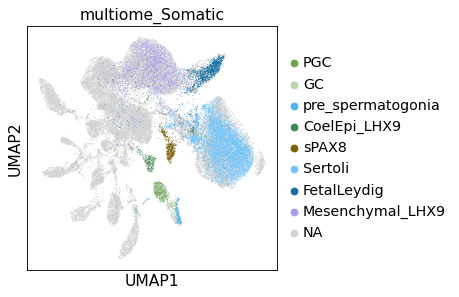

In [47]:
sc.pl.umap(adata, color = 'multiome_Somatic', 
          groups = ['PGC', 'GC', 'pre_spermatogonia','CoelEpi_LHX9', 'sPAX8', 'Sertoli',
                                                                                      'FetalLeydig', 'Mesenchymal_LHX9', ],
           palette = ['#6aa84f', '#b6d7a8', '#53b1ed', '#378b4e', '#7f6000', '#71c6fc', '#1270a3', '#a89ced'],
          save = '_multiome_all')

#### Import detailed annotations from somatic compartment  

In [10]:
import pandas as pd 
somatic_annotations = pd.read_csv('/nfs/team292/vl6/my_MULTIOME_dir/supporting_july2021/supporting_annotations.csv', index_col = 0)
somatic_annotations.head()

/opt/conda/envs/atac_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


cellatac_clusters  n_genes_by_counts  \
01-AAACAGCCACTAGCGT-1                  9                210   
01-AAACCGGCAACCCTCC-1                  9                368   
01-AAACCGGCAAGTAAGC-1                  9                182   
01-AAACGGATCCGCCAAA-1                  9               2472   
01-AAACGTACAGGTTATT-1                  8                479   

                       log1p_n_genes_by_counts  total_counts  \
01-AAACAGCCACTAGCGT-1                 5.351858         210.0   
01-AAACCGGCAACCCTCC-1                 5.910797         368.0   
01-AAACCGGCAAGTAAGC-1                 5.209486         182.0   
01-AAACGGATCCGCCAAA-1                 7.813187        2472.0   
01-AAACGTACAGGTTATT-1                 6.173786         479.0   

                       log1p_total_counts  pct_counts_in_top_50_genes  \
01-AAACAGCCACTAGCGT-1            5.351858                   23.809524   
01-AAACCGGCAACCCTCC-1            5.910797                   13.586957   
01-AAACCGGCAAGTAAGC-1            5.209486                   27.472527   
01-AAACGGATCCGCCAAA-1            7.813187                    2.022654   
01-AAACGTACAGGTTATT-1            6.173786                   10.438413   

                       pct_counts_in_top_100_genes  \
01-AAACAGCCACTAGCGT-1                    47.619048   
01-AAACCGGCAACCCTCC-1                    27.173913   
01-AAACCGGCAAGTAAGC-1                    54.945055   
01-AAACGGATCCGCCAAA-1                     4.045307   
01-AAACGTACAGGTTATT-1                    20.876827   

                       pct_counts_in_top_200_genes  \
01-AAACAGCCACTAGCGT-1                    95.238095   
01-AAACCGGCAACCCTCC-1                    54.347826   
01-AAACCGGCAAGTAAGC-1                   100.000000   
01-AAACGGATCCGCCAAA-1                     8.090615   
01-AAACGTACAGGTTATT-1                    41.753653   

                       pct_counts_in_top_500_genes multiome_Somatic  ...  \
01-AAACAGCCACTAGCGT-1                   100.000000        preGC_IIb  ...   
01-AAACCGGCAACCCTCC-1                   100.000000        granulosa  ...   
01-AAACCGGCAAGTAAGC-1                   100.000000        granulosa  ...   
01-AAACGGATCCGCCAAA-1                    20.226537        preGC_IIb  ...   
01-AAACGTACAGGTTATT-1                   100.000000        preGC_IIa  ...   

                       early_somatic CoelEpi_GATA2 late_sPAX8 granulosa  \
01-AAACAGCCACTAGCGT-1            0.0           0.0        0.0  0.240985   
01-AAACCGGCAACCCTCC-1            0.0           0.0        0.0  0.084440   
01-AAACCGGCAAGTAAGC-1            0.0           0.0        0.0  0.000000   
01-AAACGGATCCGCCAAA-1            0.0           0.0        0.0  0.000000   
01-AAACGTACAGGTTATT-1            0.0           0.0        0.0  0.032612   

                            max  leiden_R  leiden_2  leiden_3  stage_numeric  \
01-AAACAGCCACTAGCGT-1  0.397496         0         0         0           21.0   
01-AAACCGGCAACCCTCC-1  0.869140         3         3         3           21.0   
01-AAACCGGCAAGTAAGC-1  0.888004         3         3         3           21.0   
01-AAACGGATCCGCCAAA-1  0.892645         6         6         6           21.0   
01-AAACGTACAGGTTATT-1  0.874909         3         3         3           21.0   

                              cell_type  
01-AAACAGCCACTAGCGT-1           Sertoli  
01-AAACCGGCAACCCTCC-1  early_supporting  
01-AAACCGGCAAGTAAGC-1  early_supporting  
01-AAACGGATCCGCCAAA-1               OSE  
01-AAACGTACAGGTTATT-1  early_supporting  

[5 rows x 40 columns]

In [11]:
somatic_annotations = somatic_annotations[somatic_annotations['sex'] == 'male']

In [12]:
somatic_annotations['cell_type'].value_counts()

Sertoli             14210
Ti                   8503
FetalLeydig          2317
CoelEpi_GATA2        1672
Oi                    805
sPAX8                 756
early_supporting      719
CoelEpi_LHX9          661
Gi                    598
preGC_IIa             307
OSE                   279
preGC_I               110
preGC_IIb              12
Name: cell_type, dtype: int64

In [13]:
somatic_annotations = somatic_annotations[somatic_annotations['cell_type'].isin(['Sertoli', 'Ti', 'Gi', 'FetalLeydig', 
        'CoelEpi_GATA2', 'sPAX8', 'early_supporting', 'CoelEpi_LHX9',])]

In [14]:
somatic_annotations['matching_barcode'] = [i[3:] for i in somatic_annotations.index.to_list()]

In [15]:
somatic_annotations['matching_barcode'] = somatic_annotations['sample'].astype(str) + '_' + somatic_annotations['matching_barcode'].astype(str)

In [16]:
adata.obs['matching_barcode'] = [i[3:] for i in adata.obs_names.to_list()]

In [17]:
adata.obs['matching_barcode'] = adata.obs['sample'].astype(str) + '_' + adata.obs['matching_barcode'].astype(str)

In [18]:
somatic_annotations = somatic_annotations.set_index('matching_barcode')

In [19]:
adata.obs['somatic_annotation'] = adata.obs['matching_barcode'].map(somatic_annotations['cell_type'].to_dict())

In [20]:
adata.obs['somatic_annotation'].value_counts(dropna = False)

NaN                 24593
Sertoli             14210
Ti                   8503
FetalLeydig          2317
CoelEpi_GATA2        1672
sPAX8                 756
early_supporting      719
CoelEpi_LHX9          661
Gi                    598
Name: somatic_annotation, dtype: int64

In [21]:
adata.obs['somatic_annotation'] = adata.obs['somatic_annotation'].fillna(adata.obs['cell_type'])

In [22]:
adata = adata[[i not in ['Supporting', 'Mesenchymal_LHX9', 'CoelEpi'] for i in adata.obs['somatic_annotation']]]

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [23]:
males_colors_somatic = {'GermCells': '#e69429', 'Sertoli' : '#71c6fc', 'FetalLeydig' : '#0485cb', 'Ti' : '#199de5',
 'CoelEpi_LHX9' : '#378b4e', 'CoelEpi_GATA2' : '#79bd5e', 'Gi' : '#d8d1ff', 'Oi' : '#ff7c73',
    'preGC_I' : '#f4cccc', 'preGC_IIa' : '#e8a7d5', 'preGC_IIb' : '#e552a6', 'granulosa' : '#ab0c67', 'sPAX8' : '#7f6000', 'OSE' : '#c565d0', 'early_supporting' : '#8165d0',
 'Mesenchymal_GATA2': '#fbbc04',
 'PV': '#d4b16c',
 'SMCs': '#daed3e',
 'Immune': '#039eaa',
 'Endothelial': '#efd6bb',
 'Epithelial': '#b4b90e',
 'Neural': '#ffde00', 'Erythroid' : '#6fd1d3'}
adata.uns['somatic_colors'] = males_colors_somatic

Trying to set attribute `.uns` of view, copying.


... storing 'somatic_annotation' as categorical


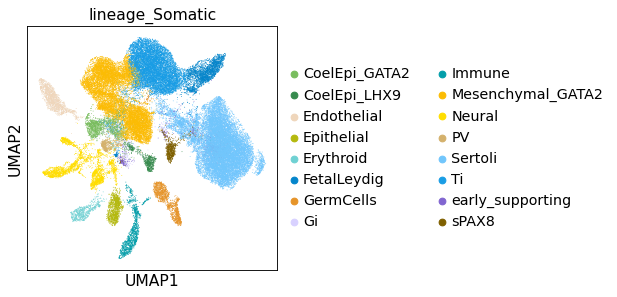

In [24]:
sc.pl.umap(adata, color = 'somatic_annotation', palette = adata.uns['somatic_colors'], title = 'lineage_Somatic', 
          save = '_lineage_somatic')

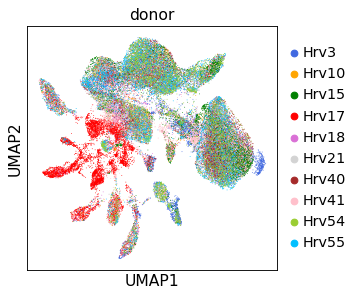

In [21]:
sc.pl.umap(adata, color = 'individual', title = 'donor', save = '_donor')

In [25]:
adata.shape

(52285, 184906)

In [26]:
adata.write(outdir + experiment_prefix + "_ATAC.wCisTopic_harmony.h5ad")

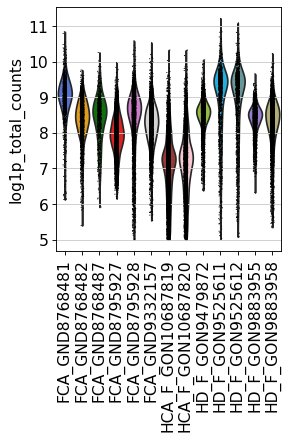

In [12]:
sc.pl.violin(adata, keys = ['log1p_total_counts'], groupby = 'sample', rotation = 90, 
            save = '_seqdepth')

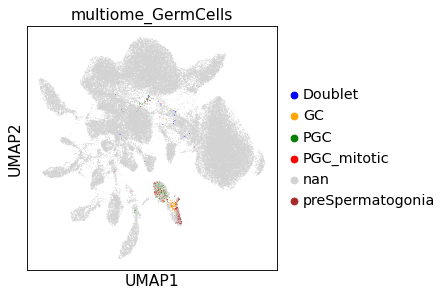

In [14]:
sc.pl.umap(adata, color = 'multiome_GermCells', save = '_multiome_GermCells', palette = ['blue', 'orange', 'green',
                                                                                        'red', 'lightgrey', 'brown'])

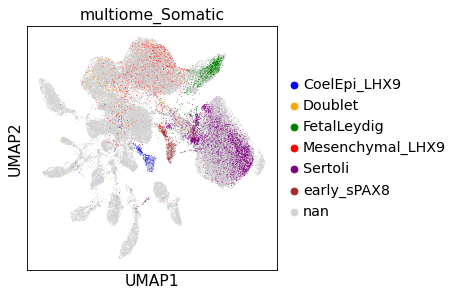

In [15]:
sc.pl.umap(adata, color = 'multiome_Somatic', save = '_multiome_Somatic')

#### Select germ cells 

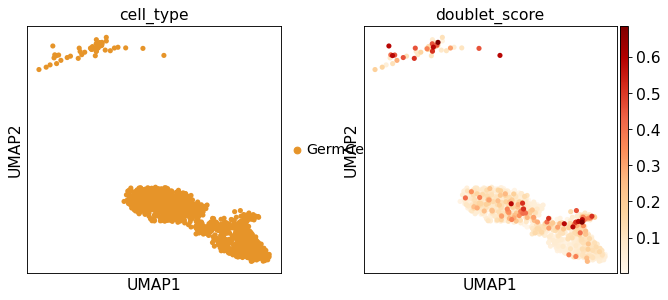

In [92]:
germ = adata[[i in ['GermCells'] for i in adata.obs['cell_type']]]
sc.pl.umap(germ, color = ['cell_type', 'doublet_score'], ncols = 2, color_map = 'OrRd')

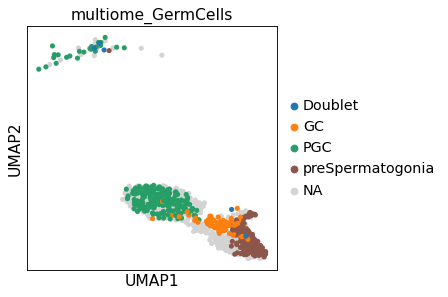

In [94]:
sc.pl.umap(germ, color = ['multiome_GermCells'], groups = ['Doublet', 'PGC', 'GC', 'preSpermatogonia'])

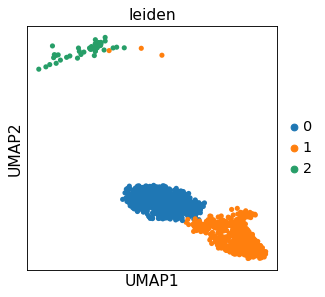

In [112]:
# Remove doublets 
sc.tl.leiden(germ, resolution = 0.1)
sc.pl.umap(germ, color = 'leiden')

In [113]:
germ = germ[[i not in ['2'] for i in germ.obs['leiden']]]
germ.shape

/opt/conda/envs/atac_env/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1358, 184906)

In [116]:
germ.obs['multiome_GermCells'].value_counts(dropna = False)

nan                 759
preSpermatogonia    197
PGC                 181
PGC_mitotic         126
GC                   93
Doublet               2
Name: multiome_GermCells, dtype: int64

In [117]:
germ = germ[[i not in ['Doublet'] for i in germ.obs['multiome_GermCells']]]

In [118]:
germ.obs[['sample', 'code', 'cell_type']].to_csv(outdir + experiment_prefix + '_germ_barcodes.csv')

#### Select somatic cells 

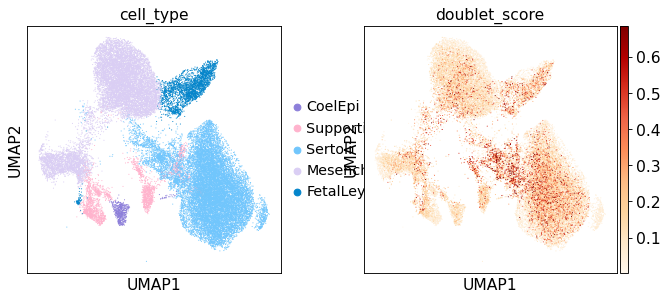

In [96]:
somatic = adata[[i in ['Mesenchymal_LHX9', 'Sertoli', 'Supporting', 'FetalLeydig', 'CoelEpi'] for i in adata.obs['cell_type']]]
sc.pl.umap(somatic, color = ['cell_type', 'doublet_score'], ncols = 2, color_map = 'OrRd')

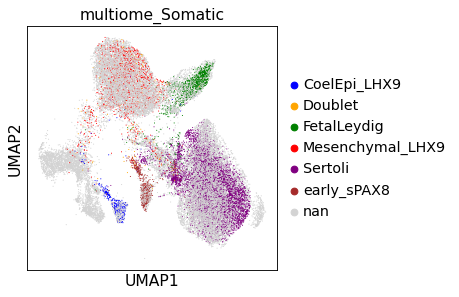

In [99]:
sc.pl.umap(somatic, color = ['multiome_Somatic'],)

In [119]:
somatic = somatic[[i not in ['Doublet'] for i in somatic.obs['multiome_Somatic']]]

In [120]:
somatic.shape

(33460, 184906)

In [122]:
somatic.obs[['sample', 'code', 'cell_type']].to_csv(outdir + experiment_prefix + '_somatic_barcodes.csv')

### End of notebook